In [116]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib import cm
import re
from sklearn.preprocessing import OneHotEncoder

pj = os.path.join
data_path = '/home/wergillius/Data/UTR_data'

In [4]:
os.path.exists(data_path)

True

In [5]:
match_celline = lambda x: re.match(r"rankedTE_(.*)\.csv",x).group(1)

In [6]:
data_fn = list(filter(lambda x : '.csv' in x or '.xlsx' in x,os.listdir(data_path)))
cell_lines = [match_celline(fn) for fn in data_fn]
cell_lines

['293T', 'A549', 'Bcells', 'Brain', 'ES', 'HeLa', 'Huh7', 'MCF10A', 'MCF7_MDA']

In [115]:
['293T', 'A549'] in cell_lines

False

In [7]:
df_ls = [pd.read_csv(pj(data_path,fn)) for fn in data_fn]
df_col = [cm.RdBu_r(i/len(cell_lines)) for i in range(len(cell_lines))]

<font size=6 color='navy'>**what to explore**</font>

- the sequence length : uniformly 
    - yes . all 100bp 
    
    
- the label : TE score
    - lognormal ?
    
    
- duplicated sequence in each cell line?
- intercept sequences across cell line ?
    - if there are, are there TEscore different? 

In [12]:
df_ls[0].head()

,NM,Gene,TEaverage,#ofSamples,Samples,UTR
0,NM_000041,APOE,2.754835,37,SRX384671 SRX870804 SRX870805 SRX870806 SRX870...,GTGAGGCCGGGTTGGGGCCGGGCTGGGGGTGGGAGGAGTCCTCACT...
1,NM_138432,SDSL,2.281592,24,SRX870804 SRX870805 SRX870806 SRX870807 SRX870...,ACCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTC...
2,NM_001278642,EDIL3,2.183342,23,SRX870804 SRX870805 SRX870806 SRX870807 SRX870...,GTAGGGGCGGAGTCTGCTGCTGCCCTGCGCTGCCACCTCGGCTACA...
3,NM_001267779,ZNF850,2.001175,22,SRX870804 SRX870805 SRX870806 SRX870807 SRX870...,TGGCCCCGAGCGGAACCAGAGAATGCTGAGGCTCTAACCATGGAAT...
4,NM_001166220,TBX20,1.859062,33,SRX384671 SRX870804 SRX870805 SRX870806 SRX870...,CGGAAACTTTGAGCTGTGTTTCGGGTCTTTGTCTCCCTTGGGGAAT...


## check length

In [15]:
for df in df_ls:
    assert sum(df.UTR.apply(lambda x: len(x)) != 100) == 0

## check TE score

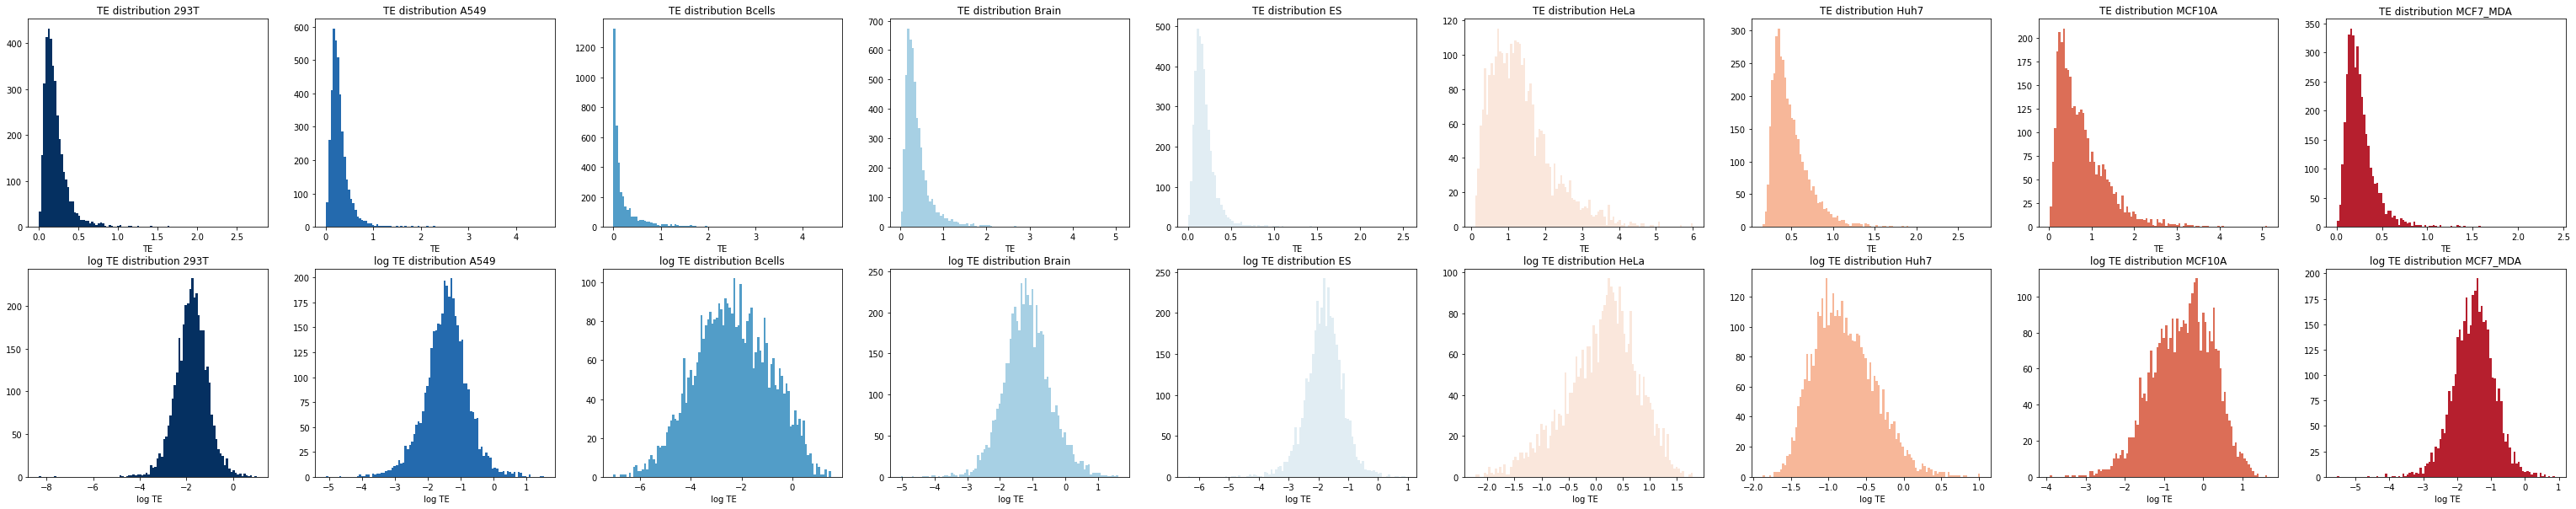

In [99]:
fig= plt.figure(figsize=(54,10))
for i in range(9):
    ax = fig.add_subplot(2,9,1+i)
    ax.hist(df_ls[i].TEaverage.values,bins=100,color=df_col[i]);
    ax.set_title('TE distribution %s' %cell_lines[i])
    ax.set_xlabel('TE')

for i in range(9):
    ax = fig.add_subplot(2,9,10+i)
    ax.hist(np.log(df_ls[i].TEaverage.values),bins=100,color=df_col[i]);
    ax.set_title('log TE distribution %s' %cell_lines[i])
    ax.set_xlabel(' log TE')

Text(0.5, 1.0, 'TE distribution')

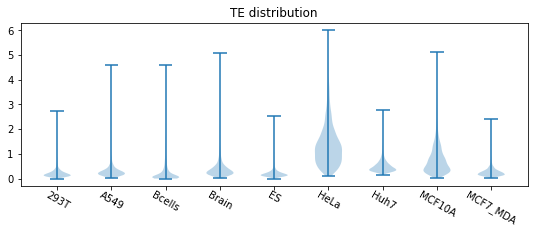

In [104]:
TE_values = [df.TEaverage.values for df in df_ls]
fig= plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,2,1)
ax.violinplot(TE_values)
ax.xaxis.set_ticks(range(1,10));
ax.xaxis.set_tick_params(pad=0,rotation=-30);
ax.set_xticklabels(cell_lines); 
ax.set_title('TE distribution')

Text(0.5, 1.0, 'TE distribution')

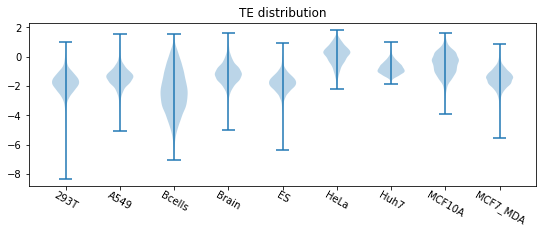

In [105]:
log_TE_values = [np.log(df.TEaverage.values) for df in df_ls]
fig= plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,2,1)
ax.violinplot(log_TE_values)
ax.xaxis.set_ticks(range(1,10));
ax.xaxis.set_tick_params(pad=0,rotation=-30);
ax.set_xticklabels(cell_lines); 
ax.set_title('TE distribution')

## interset data ?

## one hot encode data

In [106]:
class Seq_data(object):
    def __init__(self,seq_type='nn'):
        self.seq_len=100
        self.seq_type =seq_type
        self.enable_encoder()
        
    def enable_encoder(self):
        if self.seq_type == 'nn':
            self.encoder = OneHotEncoder(sparse=False)
            self.encoder.drop_idx_ = None
            self.encoder.categories_ = [np.array(['A', 'C', 'G', 'T'], dtype='<U1')]*self.seq_len

    def discretize_seq(self,data):
        if type(data) is pd.DataFrame:
            return np.stack(data.UTR.apply(lambda x: list(x)))
        elif type(data) is str:
            return np.array(list(data))
    
    def transform(self,data,flattern=True):
        X = self.encoder.transform(data)                             # 400 for each seq
        X_M = np.stack([seq.reshape(self.seq_len,4) for seq in X])   # i.e 100*4
        return X if flattern else X_M
       

In [103]:
Seq_d = Seq_data()

In [104]:
Seq_d.transform(data)

array([[0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [102]:
type(df_ls[0]) is pd.DataFrame

True

In [60]:
data = np.stack(df_ls[0].UTR.apply(lambda x: list(x)))

In [62]:
data.shape

(3679, 100)

In [95]:
encoder = OneHotEncoder(sparse=False,)
encoder.categories_ = [np.array(['A', 'C', 'G', 'T'], dtype='<U1')]*100
encoder.drop_idx_ = None
encoder.transform(data)

array([[0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

### try our `Seq_one_hot`

In [107]:
from utils import Seq_one_hot

In [109]:
soh = Seq_one_hot()

In [ ]:
from 